# Skin-NonSkin

In [1]:
import sys
sys.path.append('/Users/IzmailovPavel/Documents/Education/Course Project/Code')
import numpy as np
import matplotlib as mpl

from matplotlib import pyplot as plt

from GP.covariance_functions import SquaredExponential
from GP.gaussian_process_classification import GPC

from sklearn.cluster import KMeans
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

from vi_svi_class_experiments import run_methods
from sklearn.datasets import load_svmlight_file
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
%matplotlib inline
%load_ext autoreload
%autoreload 2

## Данные

In [9]:
x_tr, y_tr = load_svmlight_file('../../../../Programming/DataSets/Classification/skin_nonskin(245057,3).txt')
x_tr, y_tr = shuffle(x_tr, y_tr, random_state=241)

x_test = x_tr[int(x_tr.shape[0] * 0.8):, :]
y_test = y_tr[int(x_tr.shape[0] * 0.8):]
y_tr = y_tr[:int(x_tr.shape[0] * 0.8)]
x_tr = x_tr[: int(x_tr.shape[0] * 0.8), :]

data_name = 'skin_nonskin'

x_tr = x_tr.toarray()
x_test = x_test.toarray()
scaler = StandardScaler()
x_tr = scaler.fit_transform(x_tr).T
x_test = scaler.transform(x_test).T

x_tr = (x_tr + 1) / 2
x_test = (x_test + 1) / 2
y_tr = y_tr[:, None]
y_test = y_test[:, None]
y_tr[y_tr == 2] = -1
y_test[y_test == 2] = -1
dim, num = x_tr.shape

print('of objects:', num)
print('of features:', dim)
print(data_name)

of objects: 196045
of features: 3
skin_nonskin


## K-Means cluster centers

In [49]:
ind_num = 20
print('Finding means...')
means = KMeans(n_clusters=ind_num, n_init=3, max_iter=100, random_state=241)
means.fit(x_tr.T)
inputs = means.cluster_centers_.T
print('...found')

Finding means...
...found


In [47]:
cov_params = np.array([5., 2., .3])

## SVM
Here we train an SVM for reference

In [19]:
svm = SVC(C=1e0)
svm.fit(x_tr.T, y_tr)

/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/sklearn/svm/base.py:472: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y_ = column_or_1d(y, warn=True)


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0, degree=3, gamma=0.0,
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

In [22]:
predicted = svm.predict(x_test.T)
accuracy_score(y_test, predicted)

0.99457275769199383

## svi-L-BFGS-B-c method

In [89]:
model_covariance_obj = SquaredExponential(np.copy(cov_params))
svi_gp = GPC(model_covariance_obj, method='svi')

In [90]:
opts = {'mode': 'full', 'maxiter': 100, 'mydisp': True}
svi_res = svi_gp.fit(x_tr, y_tr, inputs=inputs, optimizer_options=opts)

Hyper-parameters at iteration 0 : [ 5.   2.   0.3  0.   0. ]
Hyper-parameters at iteration 1 : [ 4.99979475  2.04104992  0.29998807  0.128254   -0.3775251 ]
Hyper-parameters at iteration 2 : [ 5.04869467  1.93221015  0.1457531   0.61011769 -1.74956675]
Hyper-parameters at iteration 3 : [ 5.07817104  1.93178787  0.07604555  1.0185674  -2.41632599]
Hyper-parameters at iteration 4 : [ 5.14593629  1.97078348  0.25075945  2.0428713  -4.02890188]
Hyper-parameters at iteration 5 : [ 5.17173546  1.94061281  0.22766717  2.35129097 -4.50065535]
Hyper-parameters at iteration 6 : [ 5.21617241  1.81677039  0.1831105   2.89215852 -5.32972502]
Hyper-parameters at iteration 7 : [ 5.23802869  1.70738981  0.17482503  3.16080889 -5.75755204]
Hyper-parameters at iteration 8 : [ 5.26722608  1.47869212  0.18778388  3.5097189  -6.34826654]
Hyper-parameters at iteration 9 : [ 5.28157281  1.20112134  0.22018018  3.72457899 -6.77934246]
Hyper-parameters at iteration 10 : [ 5.24182642  0.92314999  0.25829313  3.

In [91]:
metric = lambda w: svi_gp.get_prediction_quality(w, x_test, y_test)
svi_x_lst, svi_y_lst = svi_res.plot_performance(metric, 't', freq=1)

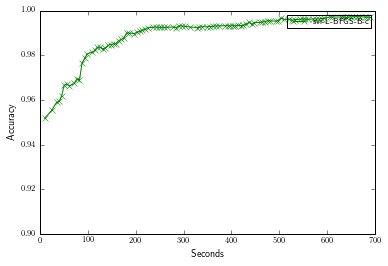

In [92]:
plt.plot(svi_x_lst[1:], svi_y_lst[1:], '-gx', label='svi-L-BFGS-B-c')
plt.ylim([0.9, 1.])
plt.legend()
plt.xlabel('Seconds')
plt.ylabel('Accuracy')

In [77]:
svi_y_lst[-1]

0.99277727903370605

## vi-means-c method
Подбор числа пересчетов

In [78]:
maxfuns = [5, 10, 15, 20]
results = []
for maxfun in maxfuns:
    print(maxfun)
    model_covariance_obj = SquaredExponential(np.copy(cov_params))
    vi_gp = GPC(model_covariance_obj, method='vi')
    opts = {'maxfun':maxfun, 'mydisp': True, 'num_updates':3}
    results.append(vi_gp.fit(x_tr, y_tr, inputs=inputs, optimizer_options=opts, max_out_iter=7))
    print()

5
Hyper-parameters at iteration 0 : [ 5.   2.   0.3]
Hyper-parameters at iteration 1 : [ 10.50989908   1.95756164   0.29381552]
Hyper-parameters at iteration 2 : [ 7.78610979  1.82450465  0.01      ]
	Hyper-parameters at outter iteration 0 : [ 7.59514399  1.78864158  0.01      ]
Hyper-parameters at iteration 0 : [ 7.59514399  1.78864158  0.01      ]
Hyper-parameters at iteration 1 : [  1.33665407e+01   1.74886444e+00   1.00000000e-02]
Hyper-parameters at iteration 2 : [  1.30704430e+01   1.75118942e+00   1.00000000e-02]
	Hyper-parameters at outter iteration 1 : [  1.25613971e+01   1.75468222e+00   1.00000000e-02]
Hyper-parameters at iteration 0 : [  1.25613971e+01   1.75468222e+00   1.00000000e-02]
Hyper-parameters at iteration 1 : [  1.40213595e+01   1.69390498e+00   1.00000000e-02]
Hyper-parameters at iteration 2 : [  1.34777661e+01   1.71672598e+00   1.00000000e-02]
Hyper-parameters at iteration 3 : [  1.33802612e+01   1.72115815e+00   1.00000000e-02]
	Hyper-parameters at outter ite

0
1
2
3


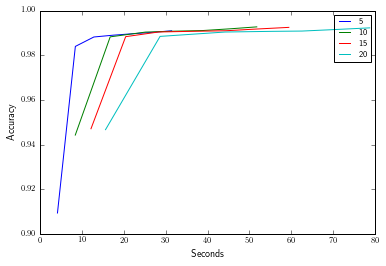

In [79]:
metric = lambda w: vi_gp.get_prediction_quality(w, x_test, y_test)
for i in range(len(maxfuns)):
    vi_x_lst, vi_y_lst = results[i].plot_performance(metric, 't', freq=1)
    plt.plot(vi_x_lst[1:], vi_y_lst[1:], label=maxfuns[i])
    print(i)
plt.ylim([0.9, 1.])
plt.legend()
plt.xlabel('Seconds')
plt.ylabel('Accuracy')

Обучение лучшего варианта

In [83]:
model_covariance_obj = SquaredExponential(np.copy(cov_params))
vi_gp = GPC(model_covariance_obj, method='vi')
opts = {'maxfun':5, 'mydisp': True, 'num_updates':3}
vi_res = vi_gp.fit(x_tr, y_tr, inputs=inputs, optimizer_options=opts, max_out_iter=20)

Hyper-parameters at iteration 0 : [ 5.   2.   0.3]
Hyper-parameters at iteration 1 : [ 10.50989908   1.95756164   0.29381552]
Hyper-parameters at iteration 2 : [ 7.78610979  1.82450465  0.01      ]
	Hyper-parameters at outter iteration 0 : [ 7.59514399  1.78864158  0.01      ]
Hyper-parameters at iteration 0 : [ 7.59514399  1.78864158  0.01      ]
Hyper-parameters at iteration 1 : [  1.33665407e+01   1.74886444e+00   1.00000000e-02]
Hyper-parameters at iteration 2 : [  1.30704430e+01   1.75118942e+00   1.00000000e-02]
	Hyper-parameters at outter iteration 1 : [  1.25613971e+01   1.75468222e+00   1.00000000e-02]
Hyper-parameters at iteration 0 : [  1.25613971e+01   1.75468222e+00   1.00000000e-02]
Hyper-parameters at iteration 1 : [  1.40213595e+01   1.69390498e+00   1.00000000e-02]
Hyper-parameters at iteration 2 : [  1.34777661e+01   1.71672598e+00   1.00000000e-02]
Hyper-parameters at iteration 3 : [  1.33802612e+01   1.72115815e+00   1.00000000e-02]
	Hyper-parameters at outter itera

Processing parameter number1/21
Processing parameter number2/21
Processing parameter number3/21
Processing parameter number4/21
Processing parameter number5/21
Processing parameter number6/21
Processing parameter number7/21
Processing parameter number8/21
Processing parameter number9/21
Processing parameter number10/21
Processing parameter number11/21
Processing parameter number12/21
Processing parameter number13/21
Processing parameter number14/21
Processing parameter number15/21
Processing parameter number16/21
Processing parameter number17/21
Processing parameter number18/21
Processing parameter number19/21
Processing parameter number20/21
Processing parameter number21/21


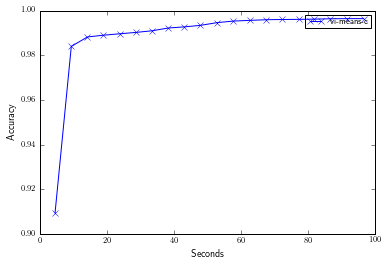

In [84]:
metric = lambda w: vi_gp.get_prediction_quality(w, x_test, y_test)
vi_x_lst, vi_y_lst = vi_res.plot_performance(metric, 't', freq=1, verbose=True)
plt.plot(vi_x_lst[1:], vi_y_lst[1:], '-bx', label='vi-means-c')
# plt.plot(svi_x_lst[1:100], svi_y_lst[1:100], '-gx', label='svi-L-BFGS-B-c')
plt.ylim([.9, 1.])
plt.legend()
plt.xlabel('Seconds')
plt.ylabel('Accuracy')

In [85]:
vi_y_lst[-1]

0.99642944584999593

### Taylor
Подбор числа пересчетов

In [57]:
model_covariance_obj = SquaredExponential(np.copy(cov_params))
vi_gp = GPC(model_covariance_obj, method='vi')
opts = {'bound': 'Taylor', 'maxfun':5, 'mydisp': True, 'num_updates':3}
vi_res = vi_gp.fit(x_tr, y_tr, inputs=inputs, optimizer_options=opts, max_out_iter=10)

Hyper-parameters at iteration 0 : [ 5.   2.   0.3]
Hyper-parameters at iteration 1 : [ 7.78771389  1.95936241  0.29407794]
Hyper-parameters at iteration 2 : [ 5.90532288  1.89980991  0.01      ]
	Hyper-parameters at outter iteration 0 : [ 6.12125042  1.89132774  0.01      ]
Hyper-parameters at iteration 0 : [ 6.12125042  1.89132774  0.01      ]
Hyper-parameters at iteration 1 : [  1.33363975e+01   1.78176899e+00   1.00000000e-02]
Hyper-parameters at iteration 2 : [  1.17401918e+01   1.80994022e+00   1.00000000e-02]
Hyper-parameters at iteration 3 : [  1.02853892e+01   1.83529501e+00   1.00000000e-02]
	Hyper-parameters at outter iteration 1 : [  1.04273886e+01   1.83486095e+00   1.00000000e-02]
Hyper-parameters at iteration 0 : [  1.04273886e+01   1.83486095e+00   1.00000000e-02]
Hyper-parameters at iteration 1 : [  1.40373523e+01   1.74809487e+00   1.00000000e-02]
Hyper-parameters at iteration 2 : [  1.39437322e+01   1.75082154e+00   1.00000000e-02]
	Hyper-parameters at outter iteratio

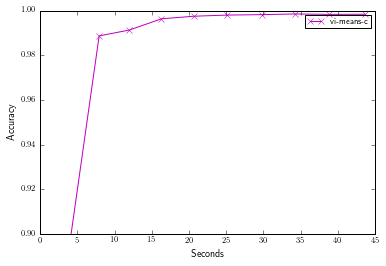

In [58]:
metric = lambda w: vi_gp.get_prediction_quality(w, x_test, y_test)
vi_t_x_lst, vi_t_y_lst = vi_res.plot_performance(metric, 't', freq=1)
plt.plot(vi_t_x_lst[1:], vi_t_y_lst[1:], '-mx', label='vi-means-c')
# plt.plot(svi_x_lst[1:100], svi_y_lst[1:100], '-gx', label='svi-L-BFGS-B-c')
plt.ylim([.9, 1.])
plt.legend()
plt.xlabel('Seconds')
plt.ylabel('Accuracy')

## svi-AdaDelta-c
Подбор длины шага

In [59]:
results = []
steps = [1., 0.5, 0.3, 0.1, 0.01]
for step in steps:
    print(step)
    model_covariance_obj = SquaredExponential(np.copy(cov_params))
    ad_gp = GPC(model_covariance_obj, method='svi', hermgauss_deg=100)

    opts = {'mode': 'adadelta', 'maxiter': 10, 'verbose': False, 'batch_size': 5000, 
            'step_rate': step}#, 'print_freq':50}
    batch_res = ad_gp.fit(x_tr, y_tr, inputs=inputs, optimizer_options=opts)
    results.append(batch_res)

1.0
0.5
0.3
0.1
0.01


/Users/IzmailovPavel/Documents/Education/Course Project/Code/GP/gaussian_process_classification.py:614: RuntimeWarning: invalid value encountered in log
  loss += np.sum(np.log(np.diag(sigma_L))) * l / N


0
1
2
3
4


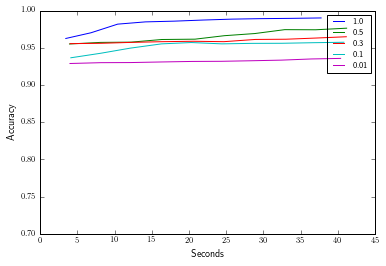

In [60]:
metric = lambda w: ad_gp.get_prediction_quality(w, x_test, y_test)
for i in range(len(results)):
    svi_ad_x_lst, svi_ad_y_lst = results[i].plot_performance(metric, 't', freq=1)
    plt.plot(svi_ad_x_lst[1:], svi_ad_y_lst[1:], label=steps[i])
    print(i)
plt.ylim([0.7, 1.])
plt.legend()
plt.xlabel('Seconds')
plt.ylabel('Accuracy')

In [86]:
model_covariance_obj = SquaredExponential(np.copy(cov_params))
ad_gp = GPC(model_covariance_obj, method='svi', hermgauss_deg=100)
opts = {'mode': 'adadelta', 'maxiter': 30, 'verbose': True, 'batch_size': 5000, 
        'step_rate': 1., 'print_freq':1}
batch_res = ad_gp.fit(x_tr, y_tr, inputs=inputs, optimizer_options=opts)

Using AdaDelta optimizer
Iteration  0 :
	Gradient norm 396.415428672
Iteration  1 :
	Gradient norm 201.269651187
Iteration  2 :
	Gradient norm 315.451515743
Iteration  3 :
	Gradient norm 144.770522476
Iteration  4 :
	Gradient norm 186.181711253
Iteration  5 :
	Gradient norm 81.8465169453
Iteration  6 :
	Gradient norm 75.9637687322
Iteration  7 :
	Gradient norm 79.9765239892
Iteration  8 :
	Gradient norm 77.5466434029
Iteration  9 :
	Gradient norm 56.5417561783
Iteration  10 :
	Gradient norm 24.3389732493
Iteration  11 :
	Gradient norm 29.2358002825
Iteration  12 :
	Gradient norm 23.9209940473
Iteration  13 :
	Gradient norm 17.4684298004
Iteration  14 :
	Gradient norm 15.4349808364
Iteration  15 :
	Gradient norm 39.1552079155
Iteration  16 :
	Gradient norm 15.8076372486
Iteration  17 :
	Gradient norm 27.1421586161
Iteration  18 :
	Gradient norm 13.5745839138
Iteration  19 :
	Gradient norm 64.6058514231
Iteration  20 :
	Gradient norm 36.9188031898
Iteration  21 :
	Gradient norm 29.611849

/Users/IzmailovPavel/Documents/Education/Course Project/Code/GP/gaussian_process_classification.py:614: RuntimeWarning: invalid value encountered in log
  loss += np.sum(np.log(np.diag(sigma_L))) * l / N


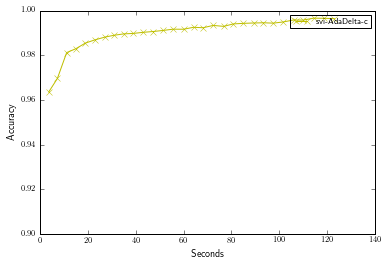

In [87]:
metric = lambda w: ad_gp.get_prediction_quality(w, x_test, y_test)
svi_ad_x_lst, svi_ad_y_lst = batch_res.plot_performance(metric, 't', freq=1)
plt.plot(svi_ad_x_lst[1:], svi_ad_y_lst[1:], '-yx', label='svi-AdaDelta-c')
plt.ylim([.9, 1.])
plt.legend()
plt.xlabel('Seconds')
plt.ylabel('Accuracy')

In [88]:
svi_ad_y_lst[-1]

0.99642944584999593

## Выводы

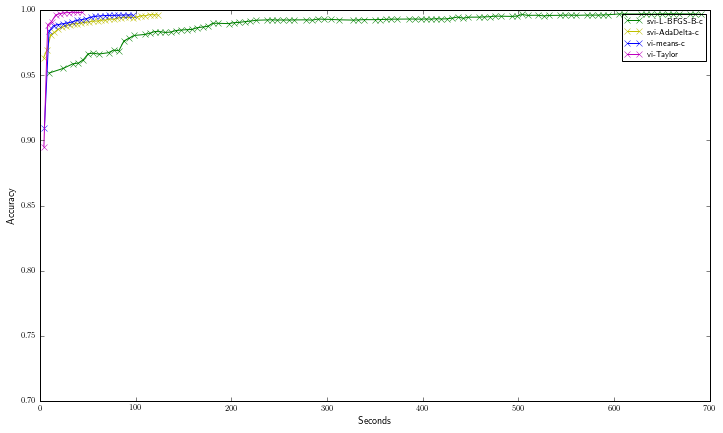

In [99]:
plt.figure(figsize=(12, 7))
plt.plot(svi_x_lst[1:], svi_y_lst[1:], '-gx', label='svi-L-BFGS-B-c')
plt.plot(svi_ad_x_lst[1:], svi_ad_y_lst[1:], '-yx', label='svi-AdaDelta-c')
plt.plot(vi_x_lst[1:], vi_y_lst[1:], '-bx', label='vi-means-c')
plt.plot(vi_t_x_lst[1:], vi_t_y_lst[1:], '-mx', label='vi-Taylor')
plt.ylim([0.7, 1.])
plt.legend()
plt.xlabel('Seconds')
plt.ylabel('Accuracy')

In [100]:
np.save('../plots/vi_vs_svi_class/'+ data_name +'_svi_x.npy', svi_x_lst)
np.save('../plots/vi_vs_svi_class/'+ data_name +'_svi_y.npy', svi_y_lst)
np.save('../plots/vi_vs_svi_class/'+ data_name +'_vi_x.npy', vi_x_lst)
np.save('../plots/vi_vs_svi_class/'+ data_name +'_vi_y.npy', vi_y_lst)
np.save('../plots/vi_vs_svi_class/'+ data_name +'_ad_x.npy', svi_ad_x_lst)
np.save('../plots/vi_vs_svi_class/'+ data_name +'_ad_y.npy', svi_ad_y_lst)

In [101]:
np.save('../plots/vi_vs_svi_class/'+ data_name +'_vi_x.npy', vi_x_lst)
np.save('../plots/vi_vs_svi_class/'+ data_name +'_vi_y.npy', vi_y_lst)
np.save('../plots/vi_vs_svi_class/'+ data_name +'_vi_t_x.npy', vi_t_x_lst)
np.save('../plots/vi_vs_svi_class/'+ data_name +'_vi_t_y.npy', vi_t_y_lst)

In [13]:
np.save('../plots/vi_vs_svi_class/'+ data_name +'_vi_st_x.npy', vi_st_x_lst)
np.save('../plots/vi_vs_svi_class/'+ data_name +'_vi_st_y.npy', vi_st_y_lst)